<a href="https://colab.research.google.com/github/binhluong84/Machine-Learning/blob/main/German_Credit_Risk_With_Target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Connect Google Drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
data = pd.read_csv('/gdrive/MyDrive/German Credit Risk - With Target/german_credit_data.csv')

In [4]:
data

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...,...
995,995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,996,40,male,3,own,little,little,3857,30,car,good
997,997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [6]:
def binary_encode(df, columns_with_positive_values):
    df = df.copy()
    for column, positive_value in columns_with_positive_values:
        df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    return df

def ordinal_encode(df, columns_with_orderings):
    df = df.copy()
    for column, ordering in columns_with_orderings:
        df[column] = df[column].apply(lambda x: ordering.index(x))
    return df

def onehot_encode(df, columns_with_prefixes):
    df = df.copy()
    for column, prefix in columns_with_prefixes:
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [7]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop duplicate id column
    df = df.drop('Unnamed: 0', axis=1)
    
    # Encode missing values as 'none'
    for column in ['Saving accounts', 'Checking account']:
        df[column] = df[column].fillna('none')
    
    # Binary encode the Sex and Risk columns
    df = binary_encode(
        df,
        columns_with_positive_values=[
            ('Sex', 'male'),
            ('Risk', 'bad')
        ]
    )
    
    # Ordinal encode the Saving accounts and Checking account columns
    df = ordinal_encode(
        df,
        columns_with_orderings=[
            ('Saving accounts', ['none', 'little', 'moderate', 'rich', 'quite rich']),
            ('Checking account', ['none', 'little', 'moderate', 'rich'])
        ]
    )
    
    # One-hot encode the Housing and Purpose columns
    df = onehot_encode(
        df,
        columns_with_prefixes=[
            ('Housing', 'H'),
            ('Purpose', 'P')
        ]
    )
    
    # Split df into X and y
    y = df['Risk'].copy()
    X = df.drop('Risk', axis=1).copy()
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    # Scale X with a standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
    
    return X_train, X_test, y_train, y_test

In [8]:
def evaluate_model(model, X_test, y_test, classification_threshold=0.5):
    
    y_true = np.array(y_test)
    
    y_pred = (model.predict_proba(X_test) >= classification_threshold).astype(np.int)
    y_pred = list(map(
        lambda x: x[1],
        y_pred
    ))
    
    print("Test Accuracy: {:.2f}%".format(accuracy_score(y_true, y_pred) * 100))
    
    cm = confusion_matrix(y_true, y_pred)
    clr = classification_report(y_true, y_pred, target_names=["Not Risky", "Risky"])
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(np.arange(2) + 0.5, ["Not Risky", "Risky"])
    plt.yticks(np.arange(2) + 0.5, ["Not Risky", "Risky"])
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

In [9]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [10]:
X_train

,Age,Sex,Job,Saving accounts,Checking account,Credit amount,Duration,H_free,H_own,H_rent,P_business,P_car,P_domestic appliances,P_education,P_furniture/equipment,P_radio/TV,P_repairs,P_vacation/others
0,-0.313046,0.685994,-1.351022,-0.212662,1.006728,-0.703098,-0.202413,-0.346410,0.634670,-0.468521,-0.330681,-0.699544,-0.114125,-0.252646,-0.46398,1.586691,-0.162459,-0.114125
1,-0.745260,-1.457738,0.174325,-0.212662,-1.027066,-0.748204,-0.727511,-0.346410,0.634670,-0.468521,3.024058,-0.699544,-0.114125,-0.252646,-0.46398,-0.630242,-0.162459,-0.114125
2,-0.572375,0.685994,-1.351022,-1.211746,2.023626,-0.628051,-1.427641,-0.346410,0.634670,-0.468521,-0.330681,1.429503,-0.114125,-0.252646,-0.46398,-0.630242,-0.162459,-0.114125
3,-0.831703,0.685994,0.174325,-0.212662,-1.027066,0.780723,0.585234,-0.346410,0.634670,-0.468521,3.024058,-0.699544,-0.114125,-0.252646,-0.46398,-0.630242,-0.162459,-0.114125
4,1.588695,-1.457738,-2.876370,-0.212662,-1.027066,-0.947679,-1.252609,-0.346410,0.634670,-0.468521,-0.330681,1.429503,-0.114125,-0.252646,-0.46398,-0.630242,-0.162459,-0.114125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,-0.572375,0.685994,1.699673,-0.212662,-0.010169,1.349210,0.322685,2.886751,-1.575623,-0.468521,-0.330681,1.429503,-0.114125,-0.252646,-0.46398,-0.630242,-0.162459,-0.114125
696,-0.140161,0.685994,1.699673,-0.212662,-0.010169,-0.077451,0.322685,2.886751,-1.575623,-0.468521,-0.330681,1.429503,-0.114125,-0.252646,-0.46398,-0.630242,-0.162459,-0.114125
697,-0.918146,-1.457738,0.174325,-1.211746,-1.027066,-0.710097,0.147653,-0.346410,-1.575623,2.134375,-0.330681,1.429503,-0.114125,-0.252646,-0.46398,-0.630242,-0.162459,-0.114125
698,0.032725,0.685994,0.174325,-0.212662,-1.027066,-0.609387,-0.727511,-0.346410,0.634670,-0.468521,3.024058,-0.699544,-0.114125,-0.252646,-0.46398,-0.630242,-0.162459,-0.114125


In [11]:
y_train

498    0
243    0
314    0
202    0
300    0
      ..
988    0
322    0
382    0
365    0
510    1
Name: Risk, Length: 700, dtype: int64

In [12]:
y_train.value_counts()

0    500
1    200
Name: Risk, dtype: int64

In [13]:
model = LogisticRegression(
    class_weight={
        0: 1,
        1: 1.5
    }
)

model.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1, 1: 1.5})

Test Accuracy: 66.00%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


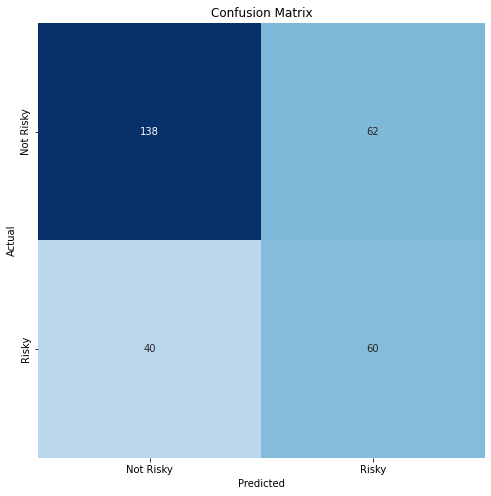

Classification Report:
----------------------
               precision    recall  f1-score   support

   Not Risky       0.78      0.69      0.73       200
       Risky       0.49      0.60      0.54       100

    accuracy                           0.66       300
   macro avg       0.63      0.65      0.64       300
weighted avg       0.68      0.66      0.67       300



In [14]:
evaluate_model(model, X_test, y_test, classification_threshold=0.4)